In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from common import *
from chromaticity_diagram import xyDiagram

In [2]:
class Spectra:
    '''记录处理前后XYZ和RGB值的类.'''
    def __init__(self):
        cmf = load_xyz_cmf()
        self.XYZ1 = cmf.to_numpy()
        self.wavelength = cmf.index.to_numpy()
        self.RGB1 = XYZ_to_sRGB(self.XYZ1)
        self.RGB2 = self.get_RGB2()
        self.XYZ2 = sRGB_to_XYZ(self.RGB2)

    def get_RGB2(self):
        raise NotImplementedError

    @property
    def Y1(self):
        return self.XYZ1[:, 1]

    @property
    def Y2(self):
        return self.XYZ2[:, 1]
    
    @property
    def RGB(self):
        return gamma_encoding(self.RGB2)
        
    def iter_xy(self, step=5):
        xyz1 = XYZ_to_xyz(self.XYZ1)
        xyz2 = XYZ_to_xyz(self.XYZ2)
        indx = np.s_[::step, :2]
        for xy1, xy2 in zip(xyz1[indx], xyz2[indx]):
            yield xy1, xy2

class ClippedSpectra(Spectra):
    info = 'Clipped to [0, 1]'
    def get_RGB2(self):
        return self.RGB1.clip(0, 1)

class ScaledSpectra(Spectra):
    info = 'Scaled to [0, 1]'
    def get_RGB2(self):
        RGB2 = self.RGB1.clip(0, None)
        RGB2 /= RGB2.max()
        
        return RGB2

class ModifiedSpectra(Spectra):
    info = 'Modified by Y'
    def get_RGB2(self):
        RGB2 = self.RGB1.clip(0, None)
        XYZ2 = sRGB_to_XYZ(RGB2)
        RGB2 *= self.XYZ1[:, [1]] / XYZ2[:, [1]]
        RGB2 /= RGB2.max()

        return RGB2

class TowardWhiteSpectra(Spectra):
    info = 'Move toward White'
    def get_RGB2(self):
        RGB2 = self.RGB1 - self.RGB1.min(axis=1, keepdims=True)
        XYZ2 = sRGB_to_XYZ(RGB2)
        RGB2 *= self.XYZ1[:, [1]] / XYZ2[:, [1]]
        RGB2 /= RGB2.max()
        
        return RGB2
    
class BrighterSpectra(TowardWhiteSpectra):
    info = 'Move toward White * 1.8'
    def get_RGB2(self):
        RGB2 = super().get_RGB2()
        RGB2 = (RGB2 * 1.8).clip(0, 1)
        
        return RGB2

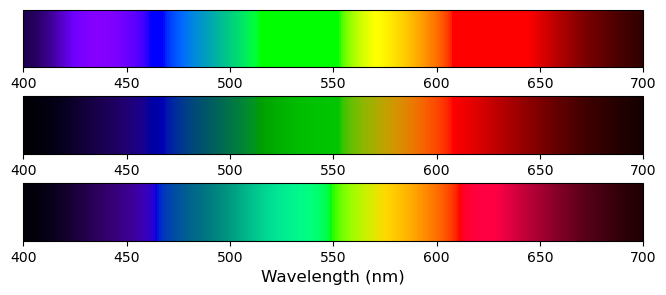

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(8, 3))
fig.subplots_adjust(hspace=0.5)

spectras = [
    ClippedSpectra(),
    ModifiedSpectra(),
    BrighterSpectra()
]
for ax, spectra in zip(axes, spectras):
    mappable = ScalarMappable(
        norm=Normalize(*spectra.wavelength[[0, -1]]),
        cmap=ListedColormap(spectra.RGB)
    )
    cbar = fig.colorbar(mappable, cax=ax, orientation='horizontal')
    ax.set_xlim(400, 700)
    cbar.set_ticks(MultipleLocator(50))

axes[-1].set_xlabel('Wavelength (nm)', fontsize='large')
fig.savefig('./fig/three_colorbars.png', dpi=300, bbox_inches='tight')

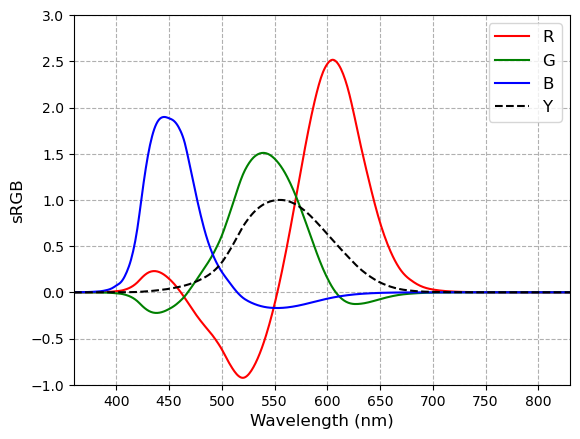

In [4]:
spectra = ClippedSpectra()
fig, ax = plt.subplots()
ax.plot(spectra.wavelength, spectra.RGB1[:, 0], c='r', label='R')
ax.plot(spectra.wavelength, spectra.RGB1[:, 1], c='g', label='G')
ax.plot(spectra.wavelength, spectra.RGB1[:, 2], c='b', label='B')
ax.plot(spectra.wavelength, spectra.Y1, c='k', ls='--', label='Y')
ax.legend(fontsize='large')

ax.set_xlim(*spectra.wavelength[[0, -1]])
ax.set_ylim(-1, 3)
ax.set_xlabel('Wavelength (nm)', fontsize='large')
ax.set_ylabel('sRGB', fontsize='large')
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.grid(ls='--')
fig.savefig('./fig/cmf_rgb.png', dpi=300, bbox_inches='tight')

In [5]:
def test_spectra(spectra, filepath=None):
    '''画出RGB和Y曲线, 单色光光谱, 色度图上的映射.'''
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.subplots_adjust(wspace=0.05)
    axes[0].plot(spectra.wavelength, spectra.RGB2[:, 0], c='r', label='R')
    axes[0].plot(spectra.wavelength, spectra.RGB2[:, 1], c='g', label='G')
    axes[0].plot(spectra.wavelength, spectra.RGB2[:, 2], c='b', label='B')
    axes[0].plot(spectra.wavelength, spectra.Y2, c='k', ls='--', label='Y')
    axes[0].legend()

    xlim = spectra.wavelength[[0, -1]]
    axes[0].set_xlim(*xlim)
    axes[0].set_ylim(-0.2, 1.2)
    axes[0].set_ylabel('sRGB', fontsize='large')
    axes[0].xaxis.set_major_locator(MultipleLocator(50))
    axes[0].yaxis.set_major_locator(MultipleLocator(0.2))
    axes[0].tick_params(labelsize='small')
    axes[0].grid(ls='--')
    axes[0].set_title(spectra.info, fontsize='x-large')

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('bottom', size=0.5, pad=0)
    norm = Normalize(*xlim)
    cmap = ListedColormap(spectra.RGB)
    mappable = ScalarMappable(norm, cmap)
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.set_ticks(MultipleLocator(50))
    cbar.set_label('Wavelength (nm)', fontsize='large')

    xyDiagram(axes[1]).draw()
    for xy1, xy2 in spectra.iter_xy():
        axes[1].plot(
            [xy1[0], xy2[0]], [xy1[1], xy2[1]],
            '.-', c='k', lw=0.6,
            mfc='w', mew=0.6
        )
    
    if filepath is not None:
        fig.savefig(filepath, dpi=300, bbox_inches='tight')

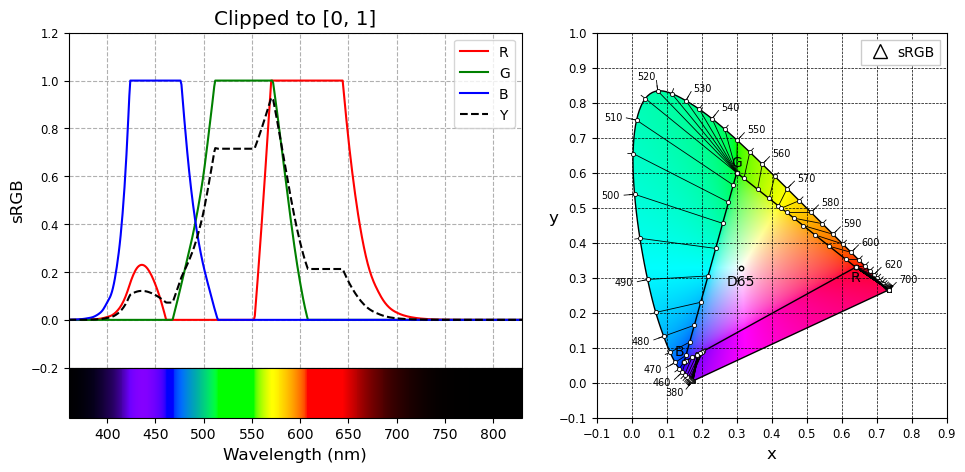

In [6]:
test_spectra(ClippedSpectra(), './fig/test_spectra1.png')

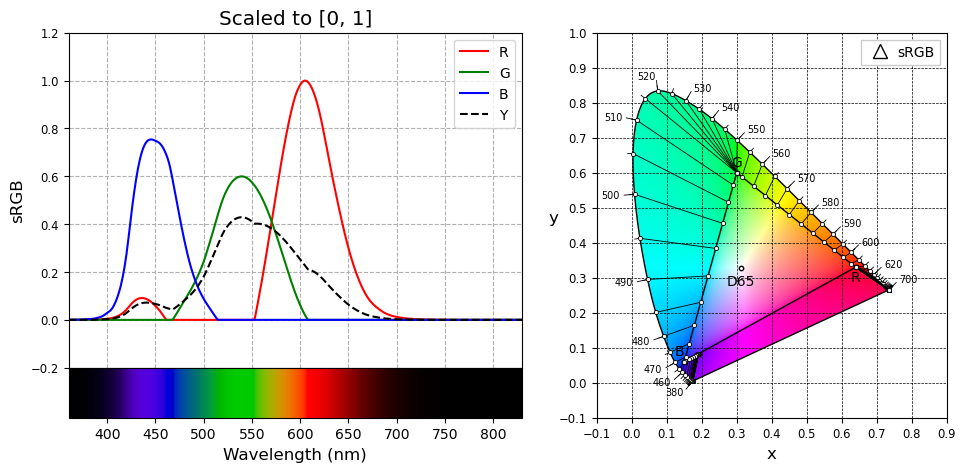

In [7]:
test_spectra(ScaledSpectra(), './fig/test_spectra2.png')

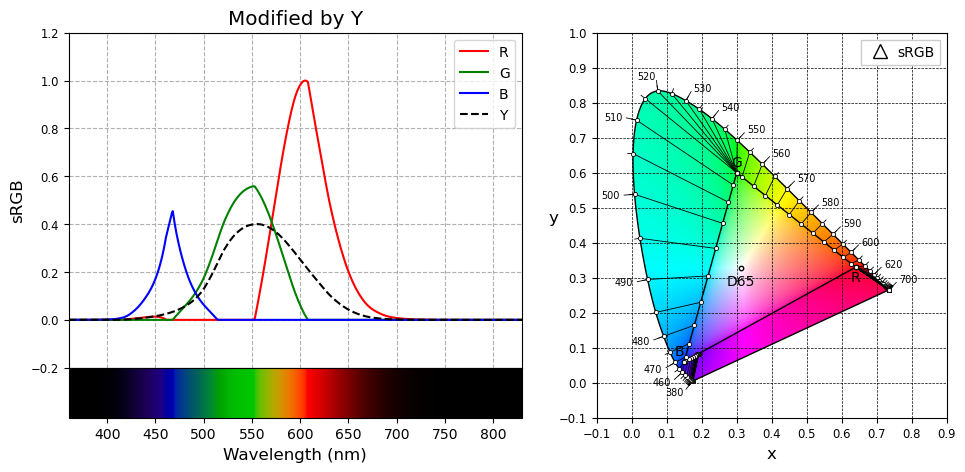

In [8]:
test_spectra(ModifiedSpectra(), './fig/test_spectra3.png')

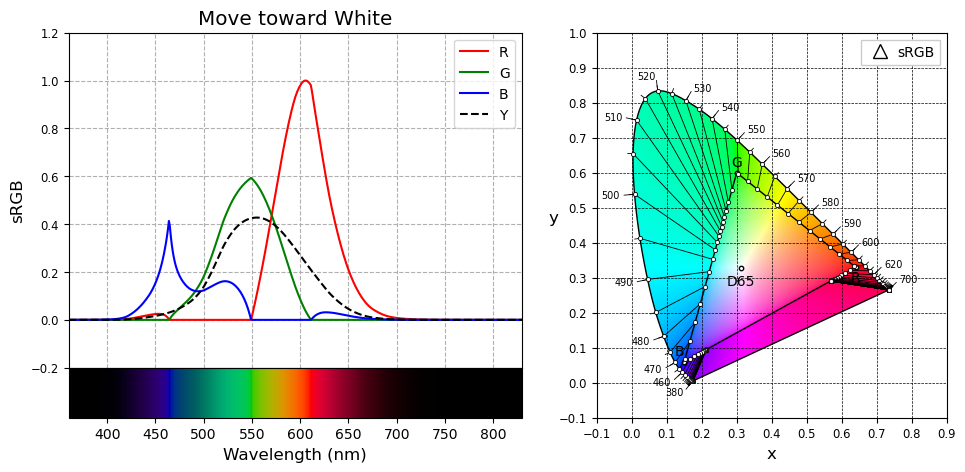

In [9]:
test_spectra(TowardWhiteSpectra(), './fig/test_spectra4.png')

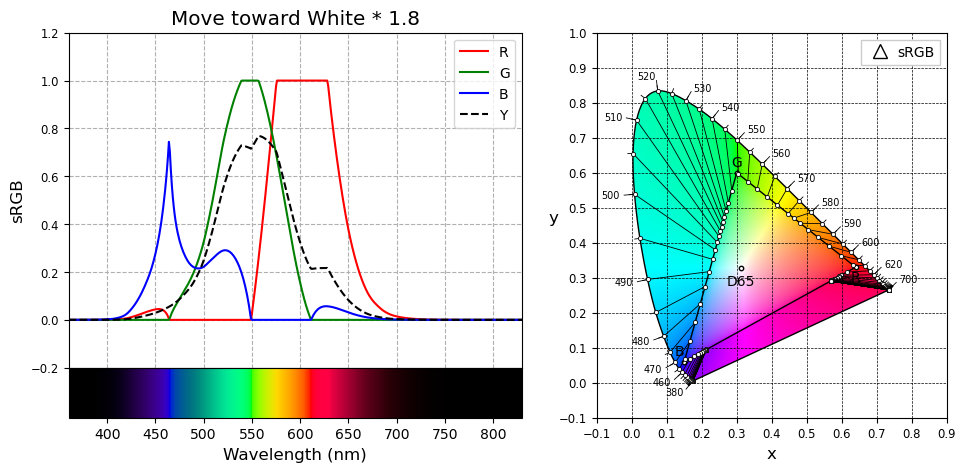

In [10]:
test_spectra(BrighterSpectra(), './fig/test_spectra5.png')